In [15]:
## Bring in needed mods
import pandas as pd, numpy as np, hypermutatorqtl as hqtl
from matplotlib import pyplot as plt
%matplotlib inline

In [16]:
## Load in QTL and genotype data
## Set path to QTL and genotype data
gtpath = '../DATA/Bt65xH99_SNP_QTL.csv.gz'

## Load in dataframe
gtd = pd.read_csv(gtpath,index_col=0)

## Gather columns of dataframe
cols = gtd.columns.tolist()

## Gather samples
prog = cols[:cols.index('Pos')]

## Subset columns
other = [k for k in cols if k not in prog]

## print columns and check
print(other)

['Pos', 'Contig', 'DPmin', 'Alt', 'Ref', 'Type', 'Altlen', 'Qual', 'NALT', 'AF', 'Bt65', 'crg1', 'Pval']


In [17]:
## Bring in phenotype data
## Set path
datapath = '../PHENOTYPE/F1-progeny-info-processed.csv.gz'

## load in
data = pd.read_csv(datapath,index_col=0)

## Gather data to use
to_use_data = data.loc[[str(pn) for pn in prog]]['Rate']

## Take log of data to use
pheno = np.log(to_use_data+1)

## Sort and view head
pheno.sort_values(ascending=False,inplace=True)

## view head
pheno.head()

19    1.745454
34    1.734977
24    1.639016
32    1.553608
44    1.408741
Name: Rate, dtype: float64

In [18]:
# List samples we know to have aneuploidy
baddies = np.array([[25],[25],[14,25],[25,34],[25],[25],[25],[25],
                    [25],[25],[13,14,25],[25],[20,25,29],[25]],dtype=object)

## Gather progeny not to use
dontuse = [str(a) for a in np.unique(np.concatenate(baddies[[2,10]]))] + ['12','41']

## Make temp list of progeny sorted by phenotype
temp_prog = [str(a) for a in pheno.sort_values().index]

## make a list of Sort progeny used
sorted_prog = [a for a in temp_prog if a not in dontuse]

## generate a index of sorted progeny names
py = range(len(sorted_prog))

## print len of progeny
len(sorted_prog)

23

In [19]:
## Set varialbes for plotting
## Set colors
h99color = 'tab:blue'
btcolor = 'tab:orange'

## Set title fontsize, xtick fontsize, 
title_fs = 26
xtfs = 14

## Set kilobase conversion factor
kb = 1000

## Set ylimis for ploting
ylims = (-0.5,len(sorted_prog)-0.5)
xlims = (0,1600)

## Set ZNF coordinates
znf = np.array([970996,976412])/kb

## Set chromoome 3 and 11 translocations
chr3_tl = 938233 / kb
chr11_tl = 1109626/ kb

In [21]:
## Gather the approximate CI for each QTL
## These were near the maximum haplotype from 
## QTL mapping experiments
## Add chromosome
gtd.Chrom = gtd.Contig

## Subset each chromosoms
chrom_3 = gtd[(gtd.Chrom=='Chr_3')]
chrom_11 = gtd[(gtd.Chrom=='Chr_11')]

## For chromosome 3
chr3_ci = np.array([chrom_3[(chrom_3.Pval >= 
                     chrom_3.Pval.max())].Pos.min()/kb,
                    chrom_3[(chrom_3.Pval >= 
                     chrom_3.Pval.max())].Pos.max()/kb])

## For chromosome 11
chr11_ci = np.array([chrom_11[(chrom_11.Pval >= 
                      chrom_11.Pval.max())].Pos.min()/kb,
                        chrom_11[(chrom_11.Pval >= 
                      chrom_11.Pval.max())].Pos.max()/kb])

## Print shapes of chromosome dataframe
chrom_3.shape[0],chrom_11.shape[0]

/home/croth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


(18159, 18069)

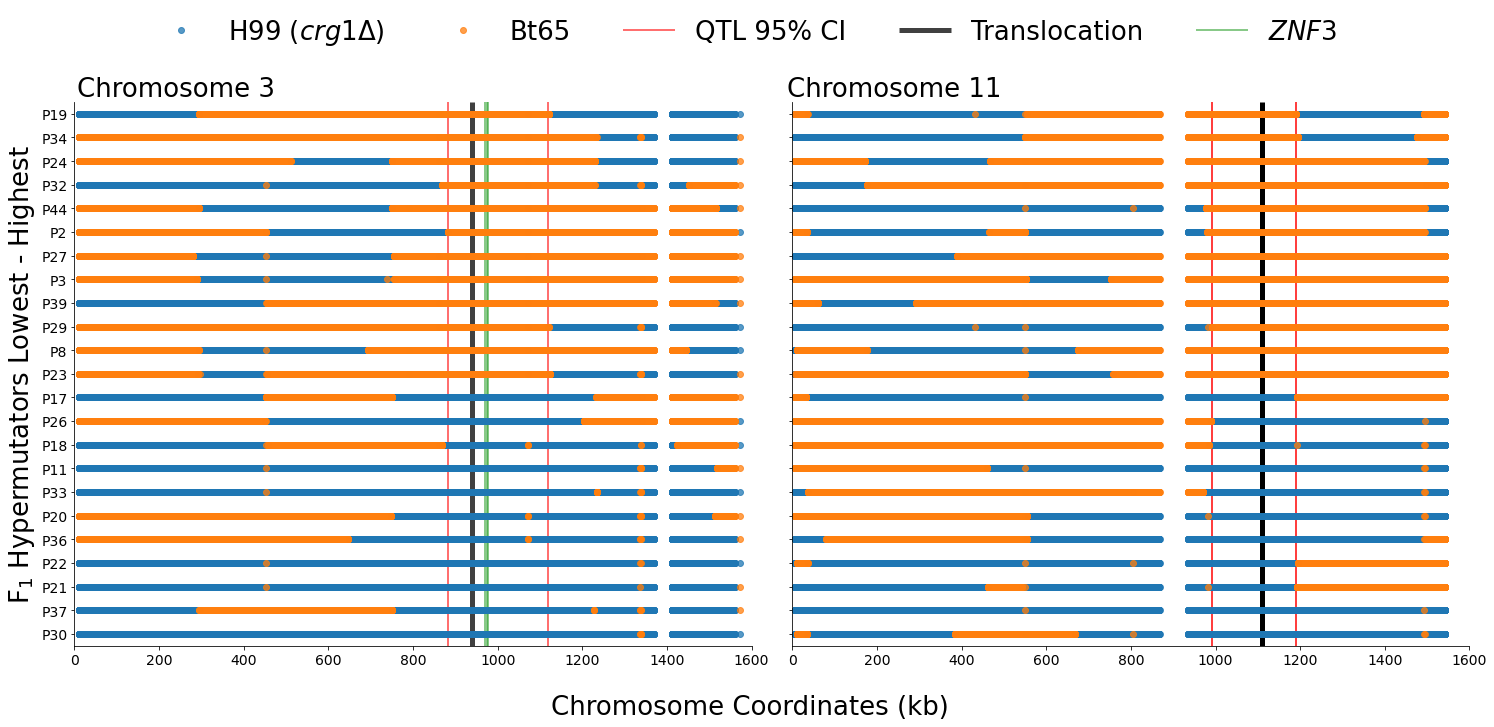

In [22]:
## Generate Figure S9 from Priest et al 2021
## Call figure and set face color
fig, ax = plt.subplots(1,2,figsize=(25,10),
                       sharey=True,sharex=True)
fig.set_facecolor('w')

## Set axis and title for chromosome 3
plt.sca(ax[0])
plt.title('Chromosome 3',fontsize= title_fs,x=0.15)

## Plot Chromosome 3 CI
plt.vlines(chr3_ci,*ylims , color='r', 
           label='QTL 95% CI',alpha=0.75,rasterized=True)

## plot chrom 3 translocation site
plt.vlines(chr3_tl,*ylims,'k', linewidth=5,
           label='Translocation',alpha=0.75,rasterized=True)

## Plot ZNF3 gene bounds
plt.vlines(znf, *ylims,'tab:green', 
           label='$ZNF3$',alpha=0.75,rasterized=True)

## Fill in lines between znf bounds
plt.vlines(np.mean(znf), *ylims,'tab:green',
           alpha=0.75,rasterized=True)

## Iterate thr progeny and plot the genotypes at SNP sites
for i,pr in enumerate(sorted_prog):
    
    ## Gather temporary genotype for chromosome 3
    temp = chrom_3[['Pos',pr]]
    
    ## plot H99 genotype
    plt.plot(temp[temp[pr]==0].Pos/kb, 
             np.repeat(py[i],len(temp[temp[pr]==0])),
             'o',color=h99color,alpha=0.75,rasterized=True,
             label='H99 ($crg1\Delta$)' if i == 0 else None)
    
    ## Plot Bt65 genotype
    plt.plot(temp[temp[pr]==1].Pos/kb,
             np.repeat(py[i],len(temp[temp[pr]==1])),
             'o',color=btcolor,alpha=0.75,rasterized=True,
             label='Bt65'if i == 0 else None)

## Change yticks to progeny names add label, change x-ticks
plt.yticks(py,['P%s'%s for s in sorted_prog],
           fontsize=xtfs)
plt.ylabel('F$_1$ Hypermutators Lowest - Highest',
           fontsize=title_fs)
plt.xticks(fontsize=xtfs)

## Conduct same plotting for chromosome 11
## Set axis and title for chromosome 11
plt.sca(ax[1])
plt.title('Chromosome 11',fontsize = title_fs,x=0.15)

## Plot chrom 11 QTL ci and translocation
plt.vlines(chr11_ci,*ylims,color='r')
plt.vlines(chr11_tl,*ylims,'k',linewidth=5);

## For each progeny iterate thru 
for i,pr in enumerate(sorted_prog):
    
    ## Gather temp genotype for progeny
    temp = chrom_11[['Pos',pr]]

    ## plot H99 allele
    plt.plot(temp[temp[pr]==0].Pos/kb,
             np.repeat(py[i],len(temp[temp[pr]==0])),
             'o',color=h99color,alpha=0.75,rasterized=True)
    
    ## Plot Bt65 allele
    plt.plot(temp[temp[pr]==1].Pos/kb,
             np.repeat(py[i],len(temp[temp[pr]==1])),
             'o',color=btcolor,alpha=0.75,rasterized=True)

## Add x label to figure
fig.text(0.5,0.04,'Chromosome Coordinates (kb)',
         fontsize=title_fs,ha='center',va='center')

## Addjust suplots
plt.subplots_adjust(wspace=0.06)

## Alter xticks
plt.xticks(fontsize=xtfs)

## Reset axis and add legend
plt.sca(ax[0]);
plt.legend(ncol=5,fontsize=title_fs,
           frameon=False,bbox_to_anchor=(1.9,1.2));

## Turn off top and right axis
[ax[i].spines[axs].set_visible(False) 
 for axs in ['top','right'] for i in range(2)];

## Set x and y limits
plt.xlim(*xlims)
plt.ylim(*ylims)

## Set file name save
filename = '../FIGURES/Figure_S9.pdf'

## Save figure as pdf
fig.savefig(filename,dpi=300,bbox_inches='tight');